# Hummingbird Classifier (Antioquia, Colombia)



In [1]:
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
from time import sleep
from duckduckgo_search import ddg_images

## Generate dataset from the internet

In [5]:
#This function returns a list of urls for images given a search term
#using duckduckgo as a search engine. 
def search_images(search_term, max_images = 100):
    return L(ddg_images(search_term, max_results=max_images)).itemgot('image')

Let's check if the function is working properly
 

In [7]:
urls = search_images('Adelomyia melanogenys', max_images = 1)
urls[0]

/home/haunted/miniconda3/envs/torch/lib/python3.8/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/home/haunted/miniconda3/envs/torch/lib/python3.8/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/home/haunted/miniconda3/envs/torch/lib/python3.8/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


'https://www.naturephoto-cz.com/photos/mraz/adelomyia-melanogenys-12x_14b422.jpg'

### Now let's download the dataset


In [2]:
#Species names taken from https://colombia.inaturalist.org/guides/6144?sort=alphaname&taxon=5562
species = ['Adelomyia melanogenys', 'Aglaiocercus coelestis', 'Aglaiocercus kingii', 'Amazilia amabilis',
        'Amazilia franciae', 'Amazilia rosenbergi', 'Amazilia saucerottei', 'Amazilia tzacatl',
        'Androdon aequatorialis', 'Anthracothorax nigricollis', 'Boissonneaua flavescens', 
        'Boissonneaua jardini', 'Chaetocercus heliodor', 'Chaetocercus mulsant', 'Chalybura buffonii',
        'Chalybura urochrysia', 'Chlorostilbon gibsoni', 'Chlorostilbon melanorhynchus', 
        'Chrysolampis mosquitus', 'Coeligena coeligena', 'Coeligena torquata', 'Colibri coruscans',
        'Colibri delphinae', 'Colibri thalassinus', 'Discosura conversii', 'Doryfera ludovicae',
        'Ensifera ensifera', 'Eriocnemis vestita', 'Eutoxeres aquila', 'Florisuga mellivora', 
        'Glaucis hirsutus', 'Haplophaedia aureliae', 'Heliangelus exortis', 'Heliodoxa imperatrix',
        'Heliodoxa jacula', 'Heliodoxa leadbeateri', 'Heliodoxa rubinoides', 'Heliomaster longirostris',
        'Heliothryx barroti', 'Hylocharis eliciae', 'Klais guimeti', 'Lafresnaya lafresnayi',
        'Lepidopyga coeruleogularis', 'Lepidopyga goudoti', 'Metallura tyrianthina', 'Ocreatus underwoodii',
        'Phaethornis anthophilus', 'Phaethornis guy', 'Phaethornis longirostris', 'Phaethornis striigularis',
        'Phaethornis syrmatophorus', 'Phaethornis yaruqui', 'Ramphomicron microrhynchum', 'Schistes geoffroyi',
        'Threnetes ruckeri', 'Urochroa bougueri']
path = Path('Dataset/species')

In [36]:
for specie in species:
    dest = (path/specie) #Where to download
    dest.mkdir(exist_ok=True, parents=True) # Create dir if it doesn't exist
    download_images(dest, urls=search_images(f'{specie}', max_images=50))
    sleep(10)
    resize_images(path/specie, max_size=400, dest=path/specie) #resize all images to save space

## Now we can train our model using Fastai library

In [37]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed) #See how many images were not downloaded succesfully and erase them

17

In [14]:
?DataBlock

In [3]:
#Create data block to load data into resnet18 for finetunning
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=73),
    get_y=parent_label,
    item_tfms=[Resize(300, method='squish')],
    batch_tfms=aug_transforms(size=224)
).dataloaders(path)

dls.bs

64

### Visualize some of the data

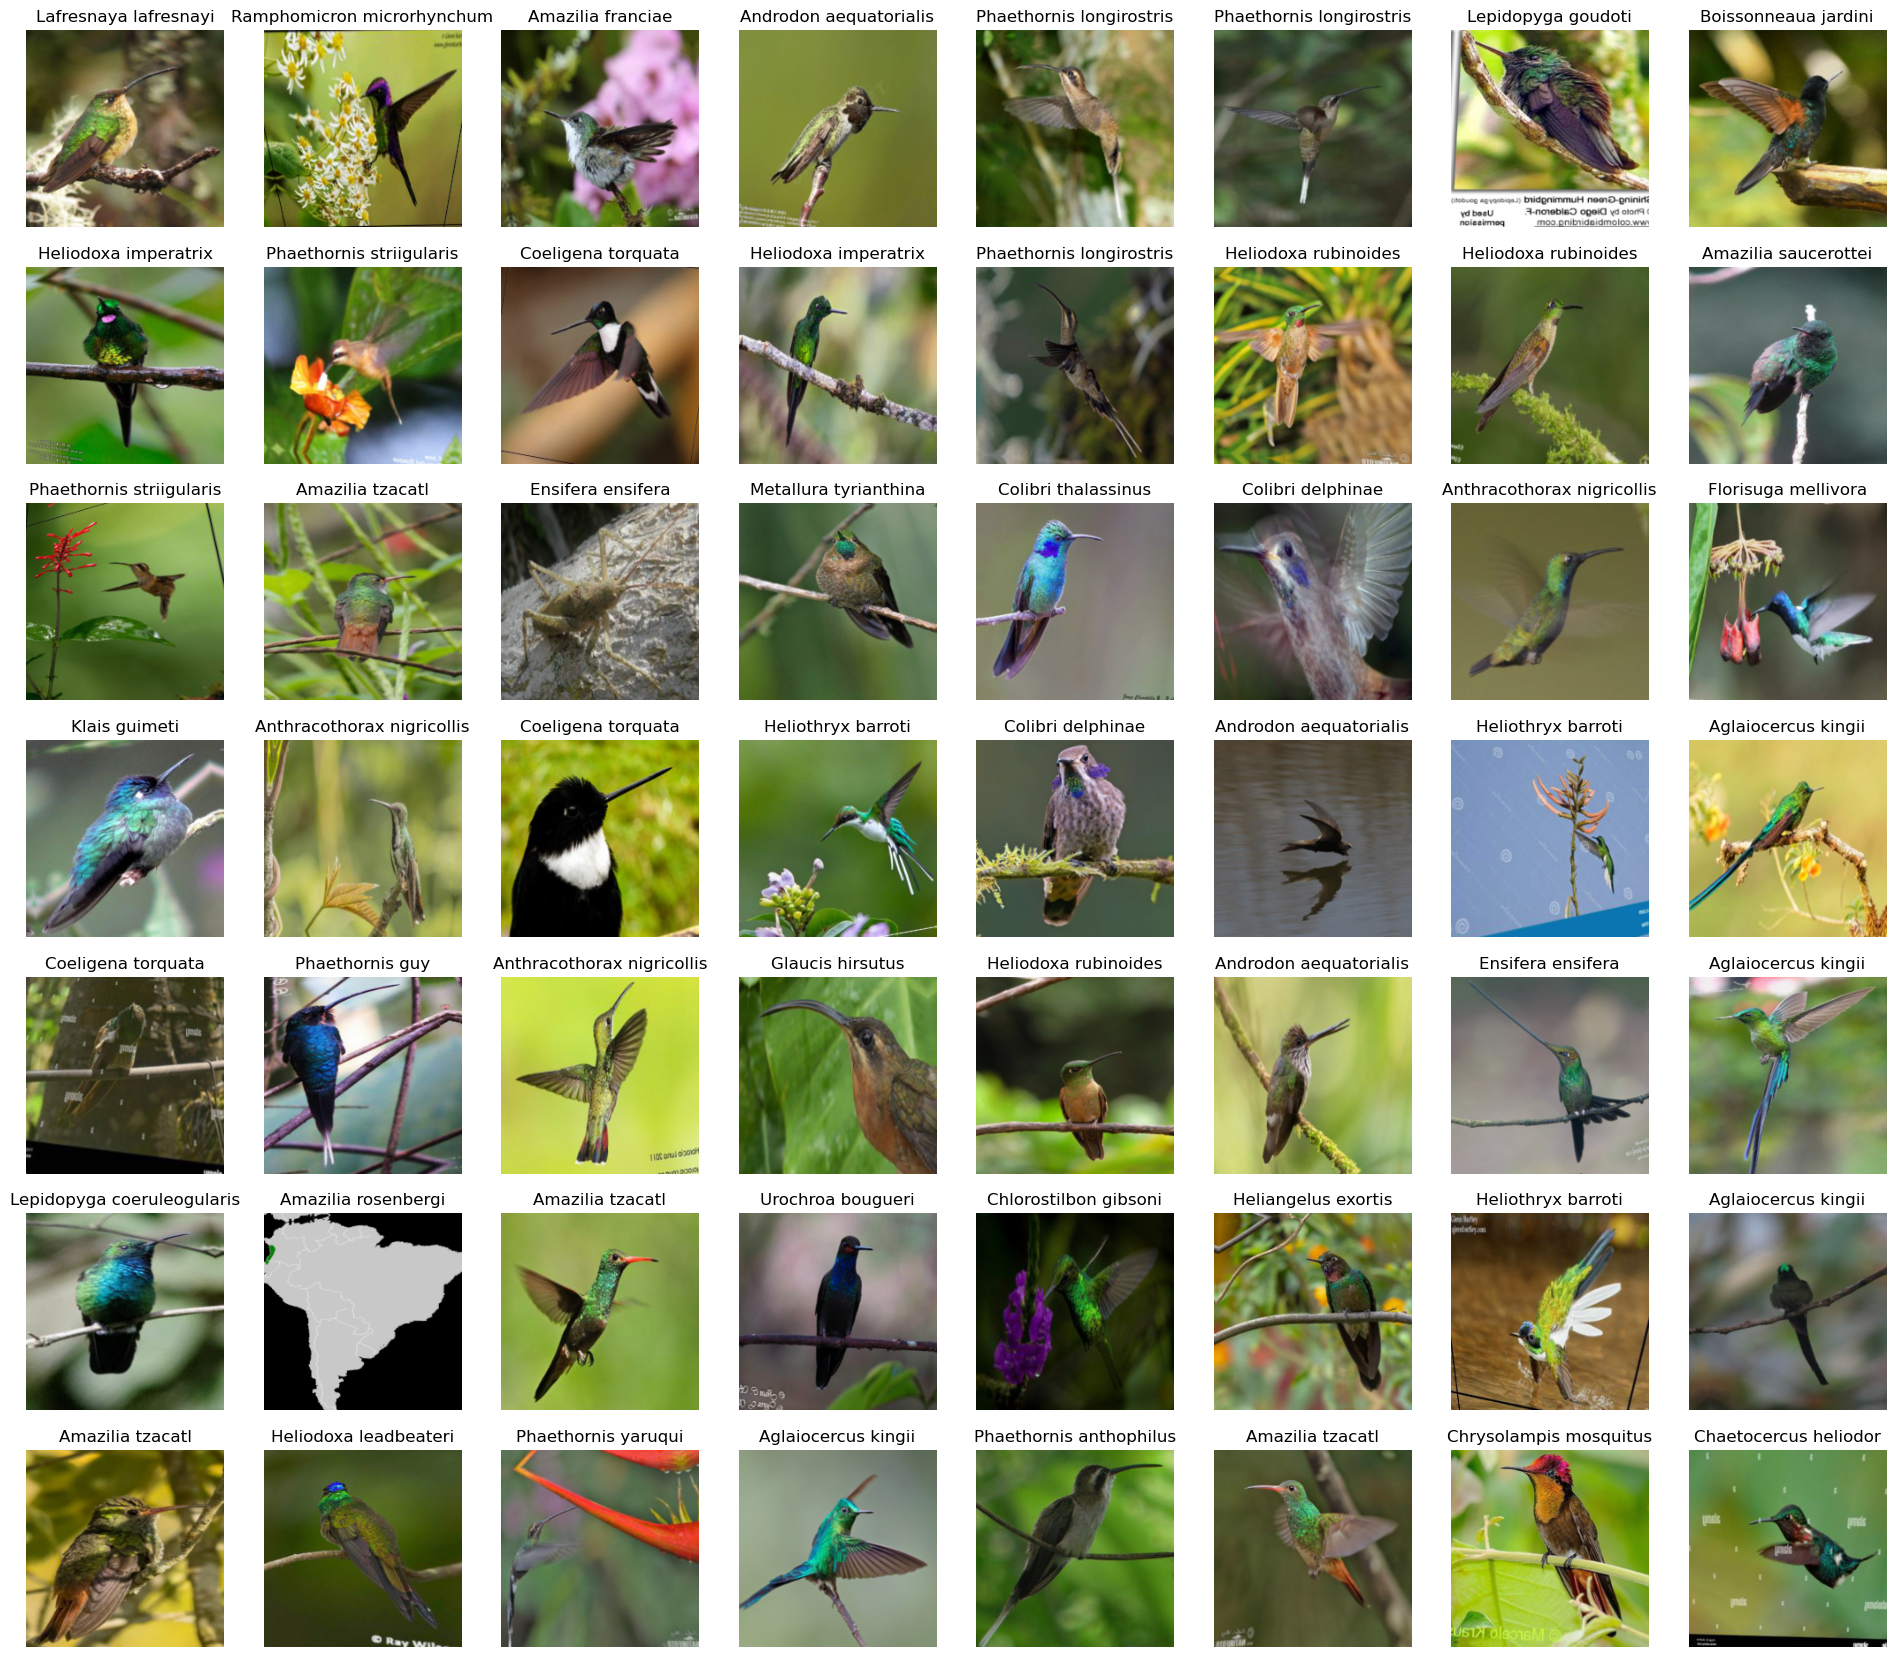

In [4]:
dls.show_batch(max_n=56) #

## Training the model

/home/haunted/miniconda3/envs/torch/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/haunted/miniconda3/envs/torch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.002511886414140463)

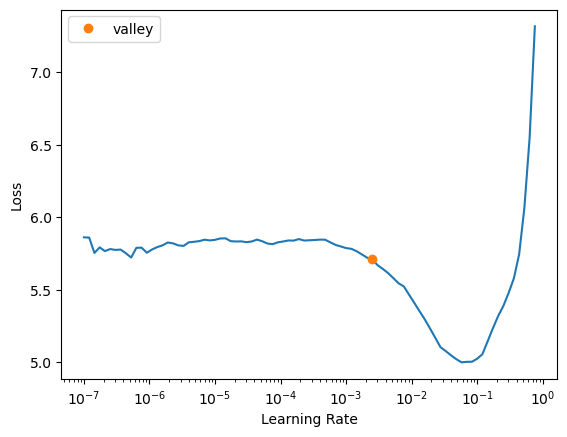

In [5]:
#Load data into a vision_learner object along with the resnet18 architecture
learn = vision_learner(dls, resnet18, metrics=error_rate)

#Find an optimal learning rate
learn.lr_find()

In [6]:
#Fine tune the model, if this doesn't run try reducing bs (batch size) in the DLS
learn.fine_tune(3, 2.5e-3)

### Now let's test the model

In [8]:
humming_type,_,probability = learn.predict(PILImage.create('test/Heliodoxa_jacula_test.jpg'))
print(f'This is a: {humming_type}')
print(f'Chances: {probability[0]:.4f}')

This is a: Heliodoxa jacula
Chances: 0.0000
